# NB2_1km_Afrotropics
## BII project land use and intensity
This notebook contains the code for extracting, pre-processing, and applying the expert decision tree and computing the intensity values of six categories of land use at a 1x1 km spatial resolution for The entire Afrotropic region. 

Inputs: Three csv files for each country of interest.  
Outputs:
1) A geofeather file with a point for every 1x1 km cell within the Afrotropic region.
2) A two-band tif file with land use and associated land use intensity.

Refer to NB1_1km_country to run the same analysis for a single country.  
Refer to NB1_8km_country to run the same analysis for a single country at an 8km spatial resolution.  
Refer to NB2_8km_Afrotropic to run the same analysis for the entire afrotropic region at an 8km spatial resolution.

### High-level steps
1. Merge csv files per country into a single afrotropic file
2. Datasets are pre-processed. Includes, filling in missing data, scaling data and correcting data types.
3. The expert decision tree is applied that outputs a land use for every point
4. Data is scaled and the intensity scores are computed

## Import packages

In [1]:
import math
import os
import glob
import pandas as pd

from osgeo import gdal
from osgeo import osr
from osgeo import ogr

import pandas as pd
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tqdm.auto import tqdm

from scipy.spatial import cKDTree
from shapely.geometry import Point

from geeml.utils import createGrid
import ee
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()
import geemap

C:\WINDOWS\System32\erty\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


# Merge files

In [2]:
def toAfrotropic(inDir, outDir, search, colnames):
    # Initialize an empty list to store the DataFrame objects
    data_frames = []

    # Loop through all subdirectories and files in the specified directory
    for subdir, dirs, files in os.walk(inDir):
        # Loop through all CSV files in the current subdirectory
        for file in glob.glob(os.path.join(subdir, search)):
            # Read in the CSV file as a DataFrame and append it to the data_frames list
            df1 = pd.read_csv(file, low_memory=False, header = None, index_col = False, skiprows=1)
            df1.columns = colnames
            data_frames.append(df1)

    # Concatenate all the DataFrames into a single DataFrame
    print(f"Merging data with length: {len(data_frames)}")
    merged_data = pd.concat(data_frames, ignore_index=True)#.drop_duplicates().reset_index(drop=True)

    # Write the merged data to a feather file
    print(f"Saving data with shape {merged_data.shape}")
    merged_data.to_csv(outDir+ "/" + search)

files = {'mean': {'search': "mean_1km.csv", 
                  'columns': ['mean_precip','Nfer_kgha', 'popDensity', 'sheepDensity', 'goatDensity', 'cattleDensity', 'gid']},
'sum': {'search': "sum_1km.csv", 
        'columns': ['areakm2_urban','areakm2_cropCover', 'areakm2_protArea',
                    'areakm2_slowNutrArea', 'areakm2_sMedNutriArea',
                    'areakm2_sHighNutriArea', 'areakm2_plantation', 'areakm2_treeCrop', 'gid']},
'coords': {'search': "coords_1km.csv", 
           'columns': ['x', 'y', 'gid']}}

dir_path = r'C:\Users\coach\myfiles\miscellenous\hayley\outputs2'
outPath = r'C:\Users\coach\myfiles\miscellenous\hayley'

for file in files:
    search = files.get(file).get('search')
    colnames = files.get(file).get('columns')
    toAfrotropic(inDir = dir_path, outDir = outPath, search = search, colnames = colnames)

Merging data with length: 45
Saving data with shape (23664079, 7)
Merging data with length: 45
Saving data with shape (23664275, 9)
Merging data with length: 45
Saving data with shape (23663358, 3)


In [2]:
date = datetime.today().strftime('%d%m%Y')
outPath = r'C:\Users\coach\myfiles\miscellenous\hayley'
os.chdir(outPath)
os.getcwd()

'C:\\Users\\coach\\myfiles\\miscellenous\\hayley'

In [3]:
def ckdnearest(gdA, gdB, k=1):
    """
    For missing values, fill with nearest value
    """

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=k)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

In [9]:
# On first run, read csv and export as feather
# df = pd.read_csv(r"coords_1km.csv", index_col = 'Unnamed: 0')
# df.to_feather(r"coords_1km.feather")
df = pd.read_feather(r"coords_1km.feather", columns = ['x', 'y', 'gid'])

In [11]:
# read sum.csv set data types and export to feather
df1 = pd.read_csv(r"sum_1km.csv", index_col = 'Unnamed: 0')
df1 = df1.loc[df1['areakm2_urban']!='86"']

df1['areakm2_urban'] = df1['areakm2_urban'].astype('float')
df1['gid'] = df1['gid'].astype('str')

df1.reset_index(drop=True).to_feather(r"sum_1km.feather")
df1 = pd.read_feather(r"sum_1km.feather")

C:\Users\coach\AppData\Local\Temp\ipykernel_3844\341516735.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(r"sum_1km.csv", index_col = 'Unnamed: 0')
C:\Users\coach\AppData\Local\Temp\ipykernel_3844\341516735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['areakm2_urban'] = df1['areakm2_urban'].astype('float')
C:\Users\coach\AppData\Local\Temp\ipykernel_3844\341516735.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1

In [19]:
# Mean covariate data
# dfmean = pd.read_csv(r"mean_1km.csv", index_col = 'Unnamed: 0').dropna()
# dfmean= dfmean[dfmean['gid']!= '245,-2948']
# dfmean.loc[:,['mean_precip', 'Nfer_kgha', 'goatDensity']] = dfmean.loc[:,['mean_precip', 'Nfer_kgha', 'goatDensity']].astype(float)
# dfmean.loc[:,['popDensity', 'cattleDensity']] = dfmean.loc[:,['popDensity', 'cattleDensity']].astype(float)
# dfmean.reset_index(drop=True).to_feather(r"mean_1km.feather")
dfmean = pd.read_feather(r"mean_1km.feather")

In [20]:
# Merge datasets into single datset based on matching GIS column
dfJoin = pd.merge(df1, dfmean, on= 'gid')
dfAll = pd.merge(dfJoin, df, on= 'gid')#.drop_duplicates().reset_index(drop=True)

In [4]:
# dfAll.to_feather('merged.feather')
dfAll = pd.read_feather('merged.feather')

In [5]:
# Fill in missing mean precipitation data
# by copying attribute of closest point
missing = dfAll.mean_precip.isna().sum()
print('The number of missing mean_precip values:', missing)
if missing>0:
    # Blocks with mean-precip data
    sdf2 = dfAll.loc[dfAll['mean_precip'].notna(), ['mean_precip', 'x', 'y']]
    gdf2 =  gpd.GeoDataFrame(sdf2.drop(['x', 'y'],axis=1), geometry = gpd.points_from_xy(sdf2.x, sdf2.y))

    # All columns without join-attributes(s) column
    sdf1 = dfAll.loc[dfAll['mean_precip'].isna(), ['gid','x', 'y']]
    gdf1 =  gpd.GeoDataFrame(sdf1.drop(['x', 'y'],axis=1), geometry = gpd.points_from_xy(sdf1.x, sdf1.y))

    joinNearest1 = ckdnearest(gdf1, gdf2)

    result1 = pd.DataFrame(joinNearest1)[['gid', 'mean_precip']]
    result1.columns = ['gid', 'mean_precip2']

    dfAll = pd.merge(dfAll, result1, how = 'outer',on = 'gid').drop_duplicates()
    dfAll['mean_precip'].fillna(dfAll['mean_precip2'], inplace = True)
    dfAll.drop('mean_precip2', axis=1, inplace=True)

The number of missing mean_precip values: 0


In [6]:
dfF = dfAll

# Format data types
dfF.loc[:,'areakm2_treeCrop'] = dfF.loc[:,'areakm2_treeCrop'].astype('float64')
dfF.loc[:,'gid'] = dfF.loc[:,'gid'].astype('string')
dfF.loc[:,'Nfer_kgha'] = dfF.loc[:,'Nfer_kgha'].astype('float64')
dfF.loc[:,'mean_precip'] = dfF.loc[:,'mean_precip'].astype('float32')

C:\Users\coach\AppData\Local\Temp\ipykernel_2872\854933499.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfF.loc[:,'gid'] = dfF.loc[:,'gid'].astype('string')
C:\Users\coach\AppData\Local\Temp\ipykernel_2872\854933499.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfF.loc[:,'mean_precip'] = dfF.loc[:,'mean_precip'].astype('float32')


In [15]:
# get sub-saharan countries
# https://code.earthengine.google.com/443ea31edb2f25f58a3346e7dc8c1064
countries = ee.FeatureCollection("USDOS/LSIB/2017")
c2 = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
afroTropics = ee.FeatureCollection("projects/ee-geethensingh/assets/Afrotropics")

africa = c2.filter(ee.Filter.eq('wld_rgn', 'Africa'))
sub = countries.filterBounds(afroTropics).aggregate_array('COUNTRY_NA')\
.removeAll(['Gaza Strip (disp)','Israel', 'Algeria', 'Egypt', 'Libya', 'Morocco', 'Tunisia', 'Mayotte (Fr)',
            'Spain [Canary Is]', 'Spain [Plazas de Soberania]', 'Portugal [Madeira Is]'])

sub_africa = countries.filter(ee.Filter.inList('COUNTRY_NA', sub))

C:\Users\coach\AppData\Local\Temp\ipykernel_2872\2742369715.py:8: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  diff = diff.explode()
C:\Users\coach\AppData\Local\Temp\ipykernel_2872\2742369715.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  diff['area'] = diff.geometry.area


<AxesSubplot: >

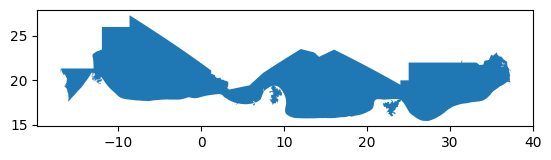

In [8]:
aoi = sub_africa.union(1000)
aoi1 = geemap.ee_to_geopandas(aoi)
aoi2 = geemap.ee_to_geopandas(afroTropics)

diff = aoi1.difference(aoi2)
# Create a new GeoDataFrame with each part of the geometry as a separate row
diff = gpd.GeoDataFrame(geometry=[part for part in diff], crs= 'EPSG:4326')
diff = diff.explode()

diff['area'] = diff.geometry.area
max_diff = diff.loc[diff['area']==diff['area'].max()]
max_diff.plot()

In [9]:
diff_aoi = geemap.geopandas_to_ee(gpd.GeoDataFrame(geometry= max_diff.geometry, crs= 'EPSG:4326'))
# diff_aoi

In [48]:
Map = geemap.Map()
Map.addLayer(diff_aoi)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [4]:
# Define projection
wkt = '\
PROJCS["Africa_Albers_Equal_Area_Conic",\
    GEOGCS["GCS_WGS_1984",\
    DATUM["WGS_1984",\
    SPHEROID["WGS_1984",6378137,298.257223563]],\
    PRIMEM["Greenwich",0],\
    UNIT["Degree",0.017453292519943295]],\
    PROJECTION["Albers_Conic_Equal_Area"],\
    PARAMETER["False_Easting",0],\
    PARAMETER["False_Northing",0],\
    PARAMETER["longitude_of_center",25],\
    PARAMETER["Standard_Parallel_1",20],\
    PARAMETER["Standard_Parallel_2",-23],\
    PARAMETER["latitude_of_center",0],\
    UNIT["Meter",1],\
    AUTHORITY["EPSG","102022"]]'

# ALbers equal area for africa
epsg_102022 = ee.Projection(wkt)

grid, _ = createGrid(1000, diff_aoi, crs = epsg_102022)
remove_ids = grid.map(lambda cell: cell.set('id', cell.id())).aggregate_array('id').getInfo()

NameError: name 'diff_aoi' is not defined

In [55]:
dfF.loc[~dfF['gid'].isin(remove_ids)].shape

(16588099, 18)

In [11]:
print(f'shape before: {dfF.shape}') 
dfF = dfF.loc[~dfF['gid'].isin(remove_ids)]
print(f'shape after: {dfF.shape}')
dfF.head()

shape before: (24219858, 17)
shape after: (21133874, 17)


,areakm2_urban,areakm2_cropCover,areakm2_protArea,areakm2_slowNutrArea,areakm2_sMedNutriArea,areakm2_sHighNutriArea,areakm2_plantation,areakm2_treeCrop,gid,mean_precip,Nfer_kgha,popDensity,sheepDensity,goatDensity,cattleDensity,x,y
0,0.0,0.0,0.0,0.999999,0.0,0.0,0.0,0.0,"299,1140",781.408203,0.0,7.829042,13.063177,5.999696,11.667612,299500,1140500
1,0.0,0.0,0.0,0.999999,0.0,0.0,0.0,0.0,"299,1140",781.408203,0.0,7.829042,13.063177,5.999696,11.667612,299500,1140500
2,0.0,0.0,0.0,0.999999,0.0,0.0,0.0,0.0,"299,1140",781.408203,0.0,7.829042,13.063177,5.999696,11.667612,299500,1140500
3,0.0,0.0,0.0,0.999999,0.0,0.0,0.0,0.0,"299,1140",781.408203,0.0,7.829042,13.063177,5.999696,11.667612,299500,1140500
4,0.0,0.0,0.0,0.999999,0.0,0.0,0.0,0.0,"299,1140",781.408203,0.0,7.829042,13.063177,5.999696,11.667612,299500,1140500


In [4]:
dfF = pd.read_feather(r"cleaned.feather")

In [5]:
# Define projection
wkt = '\
PROJCS["Africa_Albers_Equal_Area_Conic",\
    GEOGCS["GCS_WGS_1984",\
    DATUM["WGS_1984",\
    SPHEROID["WGS_1984",6378137,298.257223563]],\
    PRIMEM["Greenwich",0],\
    UNIT["Degree",0.017453292519943295]],\
    PROJECTION["Albers_Conic_Equal_Area"],\
    PARAMETER["False_Easting",0],\
    PARAMETER["False_Northing",0],\
    PARAMETER["longitude_of_center",25],\
    PARAMETER["Standard_Parallel_1",20],\
    PARAMETER["Standard_Parallel_2",-23],\
    PARAMETER["latitude_of_center",0],\
    UNIT["Meter",1],\
    AUTHORITY["EPSG","102022"]]'

# ALbers equal area for africa
epsg_102022 = ee.Projection(wkt)

In [ ]:
# Fill in missing Nutrient data
# Copy attribute of closest point
df = dfF
df['maxN'] = df[['areakm2_slowNutrArea','areakm2_sMedNutriArea', 'areakm2_sHighNutriArea']].max(axis=1)

missing = df[df.maxN==0].shape[0]
print('The number of missing soil nutrient values:', missing)
if missing>0:
    # Blocks with Nutrient areas
    sdf2 = df.loc[df['maxN']>0, ['areakm2_slowNutrArea','areakm2_sMedNutriArea', 'areakm2_sHighNutriArea', 'x', 'y']]
    gdf2 =  gpd.GeoDataFrame(sdf2.drop(['x', 'y'],axis=1), geometry = gpd.points_from_xy(sdf2.x, sdf2.y))

    # All columns without join-attributes(s) column
    sdf1 = df[['gid', 'x', 'y']]
    gdf1 =  gpd.GeoDataFrame(sdf1.drop(['x', 'y'],axis=1), geometry = gpd.points_from_xy(sdf1.x, sdf1.y))

    joinNearest1 = ckdnearest(gdf1, gdf2)

    result1 = pd.DataFrame(joinNearest1)[['gid', 'areakm2_slowNutrArea','areakm2_sMedNutriArea', 'areakm2_sHighNutriArea']]
    result1.columns = ['gid', 'areakm2_slowNutrArea2','areakm2_sMedNutriArea2', 'areakm2_sHighNutriArea2']

    finaldf = pd.merge(df, result1, how = 'outer',on = 'gid')
else:
    finaldf = df

The number of missing soil nutrient values: 138889


In [6]:
print(f"max rainfall:{finaldf.mean_precip.max()}")
while finaldf.mean_precip.max() >20000:
    print(f"max rainfall:{finaldf.mean_precip.max()}")
    finaldf = finaldf[finaldf.mean_precip<finaldf.mean_precip.max()]
finaldf.mean_precip.max()

max rainfall:8409155371008.0
max rainfall:8409155371008.0
max rainfall:5064011.0


In [7]:
# Add small value to zero precip
finaldf.loc[finaldf.mean_precip==0, 'mean_precip'] = 0.1
# Round of to the nearest 400
max_round = math.ceil(max(finaldf['mean_precip']) / 400) * 400
cut_bins = list(range(0, max_round+1, 400))
# discretize precipitation into categories 
cut_labels = [str(item) for item in range(0, len(cut_bins)-1)]
finaldf["precipDiscrete"] = pd.cut(x = finaldf["mean_precip"].astype(float), bins= cut_bins, labels = cut_labels)
print(finaldf.precipDiscrete.value_counts())

# Identify the max nutrient area
finaldf['maxNutr'] = finaldf[['areakm2_slowNutrArea2','areakm2_sMedNutriArea2', 'areakm2_sHighNutriArea2']].idxmax(axis=1)

# Get unique category based on precip bucket and max nutrient category
finaldf['combination_LS_intensity'] = finaldf[['precipDiscrete','maxNutr']].agg(tuple, axis=1)
finaldf['lsIntensityCat'] = finaldf['combination_LS_intensity'].factorize()[0]

0     4985764
2     4703990
1     4490010
3     3676522
4     2090591
5      371439
6      178543
7       65980
8       21441
9        2468
10        199
Name: precipDiscrete, dtype: int64


In [8]:
# Get unique combinations of precipitation and maxNutrient categories
combinations = list(set(finaldf['lsIntensityCat']))
print("Livestock Intensity categories (based on unique combinations of discretised precipitation and max nutrient category):",combinations)

# Compute the sum of sheep, goat and cattle density
finaldf['lsSum'] = finaldf[['sheepDensity', 'goatDensity', 'cattleDensity']].sum(axis=1)

# Scale data
finaldf['scaled_livestockIntensity']= 0
for combination in tqdm(combinations):
    qq99 = finaldf.loc[(finaldf['lsIntensityCat'] == combination),'lsSum'].quantile(0.99)
    print(f'The 99th percentile of summed livestock density for combination {combination} is: {qq99}')
    # if there are rows
    if finaldf.loc[(finaldf['lsIntensityCat'] == combination)&(finaldf['lsSum']<qq99), 'scaled_livestockIntensity'].shape[0]>0:
        # apply min max scaling to all data less than 99th quantile per unique combination.
        scaler = MinMaxScaler()
        finaldf.loc[(finaldf['lsIntensityCat'] == combination)&(finaldf['lsSum']<qq99), 'scaled_livestockIntensity']\
        = scaler.fit_transform(pd.DataFrame(finaldf.loc[(finaldf['lsIntensityCat'] == combination)&(finaldf['lsSum']<qq99)\
                                                    , 'lsSum']))
    else: 
        finaldf.loc[(finaldf['lsIntensityCat'] == combination)&(finaldf['lsSum']<qq99), 'scaled_livestockIntensity'] =\
        finaldf.loc[(finaldf['lsIntensityCat'] == combination)&(finaldf['lsSum']<qq99), 'scaled_livestockIntensity']
    # for data greater than 99th percentile per category, equal to max value 1
    finaldf.loc[(finaldf['lsIntensityCat'] == combination)&(finaldf['lsSum']>=qq99), 'scaled_livestockIntensity'] = 1

Livestock Intensity categories (based on unique combinations of discretised precipitation and max nutrient category): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


  0%|          | 0/28 [00:00<?, ?it/s]

The 99th percentile of summed livestock density for combination 0 is: 450.0038024777067
The 99th percentile of summed livestock density for combination 1 is: 332.6190599041766
The 99th percentile of summed livestock density for combination 2 is: 245.2022127980789
The 99th percentile of summed livestock density for combination 3 is: 257.6245400383198
The 99th percentile of summed livestock density for combination 4 is: 319.5076179159332
The 99th percentile of summed livestock density for combination 5 is: 243.3486251118582
The 99th percentile of summed livestock density for combination 6 is: 230.70352355836988
The 99th percentile of summed livestock density for combination 7 is: 303.6019580458383
The 99th percentile of summed livestock density for combination 8 is: 385.39497771238024
The 99th percentile of summed livestock density for combination 9 is: 416.54549035623086
The 99th percentile of summed livestock density for combination 10 is: 231.77507812956472
The 99th percentile of summ

In [9]:
for cid in combinations:
    data = finaldf.loc[(finaldf['lsIntensityCat'] == cid), 'scaled_livestockIntensity']
    print(f"combination {cid} has a max value of {data.max()}") 
    print(f"combination {cid} has a min value of {data.min()}") 

combination 0 has a max value of 1.0
combination 0 has a min value of 0.0
combination 1 has a max value of 1.0
combination 1 has a min value of 0.0
combination 2 has a max value of 1.0
combination 2 has a min value of 0.0
combination 3 has a max value of 1.0
combination 3 has a min value of 0.0
combination 4 has a max value of 1.0
combination 4 has a min value of 0.0
combination 5 has a max value of 1.0
combination 5 has a min value of 0.0
combination 6 has a max value of 1.0
combination 6 has a min value of 0.0
combination 7 has a max value of 1.0
combination 7 has a min value of 0.0
combination 8 has a max value of 1.0
combination 8 has a min value of 0.0
combination 9 has a max value of 1.0
combination 9 has a min value of 0.0
combination 10 has a max value of 1.0
combination 10 has a min value of 0.0
combination 11 has a max value of 1.0
combination 11 has a min value of 0.0
combination 12 has a max value of 1.0
combination 12 has a min value of 0.0
combination 13 has a max value o

In [10]:
# Export data
date = datetime.today().strftime('%d%m%Y')
outfile = f'1km_{date}.feather'
print(f"shape before {finaldf.shape}")
finaldf.reset_index(drop=True).to_feather(outfile)
# finaldf.drop_duplicates().reset_index(drop=True).to_feather(outfile)
# print(f"shape after {finaldf.drop_duplicates().reset_index(drop=True).shape}")

shape before (20586947, 27)


## Expert Decision tree

In [11]:
def ckdnearest_fsz(gdA, gdB, k=5):
    """
    For rows with no field size data, identify the 5-closest points -> select the most common fieldSize.
    If there are 2 most field sizes, drop the furthest point and redetermine most common field Size.
    
    Args:
        gdA (pandas DataFrame): contains rows with missing data in column named 'fieldSize'
        gdB (pandas DataFrame): contains rows with no missing data in column named 'fieldSize'
        k (int): Determines the number of closest points considered
    
    Returns:
        gdA (pandas dataframe) with filled in missing data at column named 'fieldSize2'.
        If the 5 points are each different fieldsizes, this function will not work.
    """
    # get 5-closest pts
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=k)
    
    gdA['fieldSize2'] = np.nan
    for row in tqdm(range(idx.shape[0])):
        # get 5 rows
        data = gdB.iloc[idx[row],:]
        # get most common fieldsize value
        if data['fieldSize'].value_counts().mode().shape[0]==1:
            most_common = data['fieldSize'].value_counts().idxmax()
            gdA.at[row, 'fieldSize2'] = most_common
        # if 2 or more values are returned, drop point with greatest distance
        else:
            fts = pd.DataFrame(np.column_stack([dist[row], idx[row]]), columns=['dist', 'idx'])
            # drop point with greatest distance
            idx_i = list(fts.loc[fts['dist']<fts['dist'].max(), 'idx'])
            data = gdB.iloc[idx_i,:]
            # get most common value
            most_common = data['fieldSize'].value_counts().idxmax()
            gdA.at[row, 'fieldSize2'] = most_common
    return gdA

In [12]:
date = datetime.today().strftime('%d%m%Y')
infile = f'1km_{date}.feather'
df = pd.read_feather(infile).dropna().reset_index(drop=True)

In [14]:
#1= Urban
#2= Timber plantations
#3= Tree Croplands
#4= CropLands
#5= Protected areas
#6= Rangelands/Near-natural lands

def ExpertDT(df):

    #6= Rangelands/Near-natural lands
    df['Land_Use'] = 6

    #5= Protected areas
    df.loc[df['areakm2_protArea']>0.2, 'Land_Use'] = 5

    #4= CropLands
    df.loc[df['areakm2_cropCover']>0.2, 'Land_Use'] = 4

    #3= Tree Croplands
    df.loc[df['areakm2_treeCrop']>0.2, 'Land_Use'] = 3

    #2= Timber plantations
    df.loc[df['areakm2_plantation']>0.2, 'Land_Use'] = 2

    #1= Urban
    df.loc[(df['areakm2_urban']>0.2)|
           (df['popDensity']>1000) , 'Land_Use'] = 1
    return df
    
result = ExpertDT(df)
print('The number of cells per landcover category')
result['Land_Use'].value_counts()

The number of cells per landcover category


6    16780973
4     2531078
5     1082818
1      138576
2       38917
3       14584
Name: Land_Use, dtype: int64

In [15]:
# FieldSize
from geemap import ee_to_geopandas
from tqdm.auto import tqdm
import ee
ee.Initialize()
aoi = ee.FeatureCollection("projects/ee-geethensingh/assets/Afrotropics")
pts = ee.FeatureCollection("projects/ee-geethensingh/assets/dominant_field_sizes")\
                                .filterBounds(aoi)\
                                .filter(ee.Filter.neq('field_size', 'NA'))\
                                .map(lambda x: x.set("fieldSize",ee.Number.parse(x.get("field_size")))\
                                ).select(['fieldSize', 'geometry'])
# Define projection
wkt = '\
PROJCS["Africa_Albers_Equal_Area_Conic",\
    GEOGCS["GCS_WGS_1984",\
    DATUM["WGS_1984",\
    SPHEROID["WGS_1984",6378137,298.257223563]],\
    PRIMEM["Greenwich",0],\
    UNIT["Degree",0.017453292519943295]],\
    PROJECTION["Albers_Conic_Equal_Area"],\
    PARAMETER["False_Easting",0],\
    PARAMETER["False_Northing",0],\
    PARAMETER["longitude_of_center",25],\
    PARAMETER["Standard_Parallel_1",20],\
    PARAMETER["Standard_Parallel_2",-23],\
    PARAMETER["latitude_of_center",0],\
    UNIT["Meter",1],\
    AUTHORITY["EPSG","102022"]]'

def largefc_to_geopandas(featurecollection, step_size = 5000):
    """
    function to convert a featurecollection with more than 5000 elements to a pandas dataframe
    
    featurecollection: earth engine feature collection with more than 5000 elements
    step_size: Th enumber of elemenst to process at once. Must be less than equal to 5000
    
    """
    df = gpd.GeoDataFrame()
    fcsize = featurecollection.size()
    fclist = featurecollection.toList(fcsize)
    _fcsize = featurecollection.size().getInfo()
    for i in tqdm(range(0,_fcsize,step_size)):
        fc = ee.FeatureCollection(fclist.slice(i,i+step_size))
        df = df.append(ee_to_geopandas(fc))
    return df

fieldSize = largefc_to_geopandas(pts).set_crs('EPSG:4326').to_crs(wkt)

    
# get rows with fieldsize, cropcover or treeCrop data-used for joining
val_list = [3502, 3503, 3504, 3505, 3506]
gdf1 = fieldSize.loc[fieldSize['fieldSize'].isin(val_list), ].reset_index(drop=True) #select all rows with valid field size data

# select landcover 3 and 4 (tree crop and crop)
dfs2 = result.loc[(result['Land_Use']==3)|(result['Land_Use']==4),['x', 'y', 'gid']].reset_index(drop=True)
# Convert to gdf
gdf2 = gpd.GeoDataFrame(dfs2.drop(['x', 'y'],axis=1), geometry = gpd.points_from_xy(dfs2.x, dfs2.y)).set_crs(wkt)

print(f'fill in {gdf2.shape[0]} missing field size values')

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\coach\AppData\Local\Temp\ipykernel_3204\1893818060.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(ee_to_geopandas(fc))
C:\Users\coach\AppData\Local\Temp\ipykernel_3204\1893818060.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(ee_to_geopandas(fc))
C:\Users\coach\AppData\Local\Temp\ipykernel_3204\1893818060.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(ee_to_geopandas(fc))
C:\Users\coach\AppData\Local\Temp\ipykernel_3204\1893818060.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(ee_to_geopandas(fc))


fill in 2545662 missing field size values


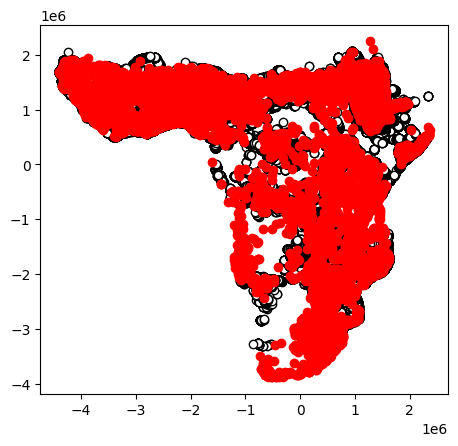

In [69]:
# Check if datasets overlap (same projection
ax = gdf2.to_crs(wkt).plot(color='white', edgecolor='black')

# plot ``GeoDataFrame``.
gdf1.to_crs(wkt).plot(ax=ax, color='red')
plt.show()

In [16]:
joinNearest = ckdnearest_fsz(gdf2, gdf1, k=5)
df1 = pd.DataFrame(joinNearest[['gid', 'fieldSize2']])

finaldf = pd.merge(result, df1, how= 'outer',on = 'gid')
finaldf['fieldSize'] = finaldf['fieldSize2'].fillna(-1).astype('int')

dfF = finaldf.drop('fieldSize2', axis=1).reset_index(drop=True)

  0%|          | 0/2545662 [00:00<?, ?it/s]

In [17]:
# Add scaled fieldSize
dfF['scaled_fieldSize'] = -1
dfF.loc[dfF['fieldSize'] == 3502, 'scaled_fieldSize'] = 1.0
dfF.loc[dfF['fieldSize'] == 3503, 'scaled_fieldSize'] = 0.75
dfF.loc[dfF['fieldSize'] == 3504, 'scaled_fieldSize'] = 0.50
dfF.loc[dfF['fieldSize'] == 3505, 'scaled_fieldSize'] = 0.25
dfF.loc[dfF['fieldSize'] == 3506, 'scaled_fieldSize'] = 0

In [18]:
# Scale variables
colnames = ['Nfer_kgha', 'popDensity']

result = dfF
for col in colnames:
    # create scaled variable
    result['scaled_'+col] = 0
    if (col=='Nfer_kgha')&(result.loc[(result['Land_Use']==3), col].shape[0]>0):
#         For tree croplands
        # get 99th percentile is equal to 0.99 quantile
        qq99 = result.loc[(result['Land_Use']==3), col].quantile(0.99)
        print(f"{col} for Tree Croplands: {qq99}")
        # apply min max scaling to all data less than 99th quantile.
        scaler = MinMaxScaler()
        result.loc[(result[col]<qq99)&(result['Land_Use']==3), 'scaled_'+ col] =\
        scaler.fit_transform(pd.DataFrame(result.loc[(result[col]<qq99)&(result['Land_Use']==3), col]))
        # for data greater than 99th percentile, equal to max value 1
        result.loc[(result[col]>=qq99)&(result['Land_Use']==3), 'scaled_' + col] = 1
    if (col=='Nfer_kgha')&(result.loc[(result['Land_Use']==4), col].shape[0]>0):
#         for croplands
        # get 99th percentile
        qq99 = result.loc[(result['Land_Use']==4), col].quantile(0.99)
        print(f"{col} for CropCover: {qq99}")
        # apply min max scaling to all data less than 99th quantile.
        scaler = MinMaxScaler()
        result.loc[(result[col]<qq99)&(result['Land_Use']==4), 'scaled_'+ col] =\
        scaler.fit_transform(pd.DataFrame(result.loc[(result[col]<qq99)&(result['Land_Use']==4), col]))
        # for data greater than 99th percentile, equal to max value 1
        result.loc[(result[col]>=qq99)&(result['Land_Use']==4), 'scaled_' + col] = 1
    if (col=='Nfer_kgha')&(result.loc[(result['Land_Use']==6), col].shape[0]>0):
#         for rangelands
        # get 99th percentile
        qq99 = result.loc[(result['Land_Use']==6), col].quantile(0.99)
        print(f"{col} for Rangeland: {qq99}")
        # apply min max scaling to all data less than 99th quantile.
        scaler = MinMaxScaler()
        result.loc[(result[col]<qq99)&(result['Land_Use']==6), 'scaled_'+ col] =\
        scaler.fit_transform(pd.DataFrame(result.loc[(result[col]<qq99)&(result['Land_Use']==6), col]))
        # for data greater than 99th percentile, equal to max value 1
        result.loc[(result[col]>=qq99)&(result['Land_Use']==6), 'scaled_' + col] = 1
        
    if col=='popDensity':
        # get 99th percentile
        qq99 = result.loc[result['Land_Use']==1, col].quantile(0.99)
        print(f"{col} for urban areas: {qq99}")
        # apply min max scaling to all data less than 99th quantile.
        scaler = MinMaxScaler()
        result.loc[(result[col]<qq99)&(result['Land_Use']==1), 'scaled_'+ col] =\
        scaler.fit_transform(pd.DataFrame(result.loc[(result[col]<qq99)&(result['Land_Use']==1), col]))
        # for data greater than 99th percentile, equal to max value 1
        result.loc[(result[col]>=qq99)&(result['Land_Use']==1), 'scaled_' + col] = 1

Nfer_kgha for Tree Croplands: 12.20016
Nfer_kgha for CropCover: 16.376
Nfer_kgha for Rangeland: 8.61856
popDensity for urban areas: 18628.4794921875


## Land Use Intensity

In [19]:
result['intensity'] = -1
result['scaled_intensity'] = -1

#1= Urban
# check if there are urban land use pixels
if result.loc[(result['Land_Use']==1), 'intensity'].shape[0]>0:
    print('Computing Intensity for Land Use 1 (urban area)')
#     scale urban area between 0 and 1 (from 0.2 to 1)
    scaler = MinMaxScaler()
    result.loc[(result['Land_Use']==1), 'scaled_areakm2_urban'] = scaler.fit_transform(pd.DataFrame(result.loc[(result['Land_Use']==1)\
                                                                                                             , 'areakm2_urban']))
#     assign intensity scores based on an equal weighting of scaled popDensity and scaled urban area
    result.loc[(result['Land_Use']==1), 'intensity'] = (result['scaled_areakm2_urban']+\
                                                        result['scaled_popDensity'])/2
#     scale raw intensity values between 0 and 1 within a land use
    scaler = MinMaxScaler()
    result.loc[(result['Land_Use']== 1), 'scaled_intensity'] = scaler.fit_transform(pd.DataFrame(result.loc[(result['Land_Use']==1)\
                                                                                                                   , 'intensity']))

#3= Tree Croplands
if result.loc[(result['Land_Use']==3), 'intensity'].shape[0]>0:
    print('Computing Intensity for Land Use 3 (tree_crop)')
    scaler = MinMaxScaler()
    result.loc[(result['Land_Use']==3), 'scaled_areakm2_treeCrop'] = scaler.fit_transform(pd.DataFrame(result.loc[(result['Land_Use']==3)\
                                                                                                                  , 'areakm2_treeCrop']))
    result.loc[(result['Land_Use']==3), 'intensity'] = (result['scaled_areakm2_treeCrop']+\
                                                        result['scaled_fieldSize']+\
                                                        result['scaled_Nfer_kgha']\
                                                       )/3
    scaler = MinMaxScaler()
    result.loc[(result['Land_Use']==3), 'scaled_intensity'] = scaler.fit_transform(pd.DataFrame(result.loc[(result['Land_Use']==3)\
                                                                                                                   , 'intensity']))

#4 = Croplands
if result.loc[(result['Land_Use']==4), 'intensity'].shape[0]>0:
    print('Computing Intensity for Land Use 4 (crop cover)')
    scaler = MinMaxScaler()
    result.loc[(result['Land_Use']==4), 'scaled_areakm2_cropCover'] = scaler.fit_transform(pd.DataFrame(result.loc[(result['Land_Use']==4)\
                                                                                                                   , 'areakm2_cropCover']))
    result.loc[(result['Land_Use']==4), 'intensity'] = (result['scaled_areakm2_cropCover']+\
                                                        result['scaled_fieldSize']+\
                                                        result['scaled_Nfer_kgha']\
                                                       )/3
    scaler = MinMaxScaler()
    result.loc[(result['Land_Use']==4), 'scaled_intensity'] = scaler.fit_transform(pd.DataFrame(result.loc[(result['Land_Use']==4)\
                                                                                                                   , 'intensity']))

#6 = Rangelands/ Near-naturallands
print('Computing Intensity for Land Use 6 (Rangelands)')
if result.loc[(result['Land_Use']==6), 'intensity'].shape[0]>0:
    result.loc[(result['Land_Use']==6), 'intensity'] = (result['scaled_livestockIntensity']+\
                                                        result['scaled_Nfer_kgha'])/2
                                                                                                                   
    scaler = MinMaxScaler()
    result.loc[(result['Land_Use']==6), 'scaled_intensity'] = scaler.fit_transform(pd.DataFrame(result.loc[(result['Land_Use']==6)\
                                                                                                                   , 'intensity']))

Computing Intensity for Land Use 1 (urban area)
Computing Intensity for Land Use 3 (tree_crop)
Computing Intensity for Land Use 4 (crop cover)
Computing Intensity for Land Use 6 (Rangelands)


In [20]:
# Export to feather
result.to_feather(f"result_1km_{date}.feather")

In [5]:
# Read feather
result = pd.read_feather(f"result_1km_16032023.feather")

In [7]:
# Define Albers equal area projection 
wkt = '\
PROJCS["Africa_Albers_Equal_Area_Conic",\
    GEOGCS["GCS_WGS_1984",\
    DATUM["WGS_1984",\
    SPHEROID["WGS_1984",6378137,298.257223563]],\
    PRIMEM["Greenwich",0],\
    UNIT["Degree",0.017453292519943295]],\
    PROJECTION["Albers_Conic_Equal_Area"],\
    PARAMETER["False_Easting",0],\
    PARAMETER["False_Northing",0],\
    PARAMETER["longitude_of_center",25],\
    PARAMETER["Standard_Parallel_1",20],\
    PARAMETER["Standard_Parallel_2",-23],\
    PARAMETER["latitude_of_center",0],\
    UNIT["Meter",1],\
    AUTHORITY["EPSG","102022"]]'

# Convert to geodataframe
gdf = gpd.GeoDataFrame(result.drop(['x', 'y','combination_LS_intensity', 'areakm2_slowNutrArea','areakm2_sMedNutriArea', 'areakm2_sHighNutriArea'], axis = 1),
                       geometry = gpd.points_from_xy(result.x, result.y), crs= wkt).to_crs(crs= 'EPSG:4326')

In [8]:
# Define columns for renaming
shp_cols = {'areakm2_urban':'km2_urban',
            'areakm2_cropCover':'km2_cropCov',
            'areakm2_protArea':'km2_protAr',
            'km2_plntn':'areakm2_plantation',
            'areakm2_treeCrop':'km2_trCrp',
            'gid':'gid',
            'mean_precip':'mean_precip',
            'Nfer_kgha':'mean_Nfer',
            'popDensity':'sum_popDen',
            'sheepDensity':'sum_shpDen',
            'goatDensity':'sum_gtDen',
            'cattleDensity':'sum_ctlDen',
            'maxN':'maxSNtrAr',
            'areakm2_slowNutrArea2':'km2_sLwNtr',
            'areakm2_sMedNutriArea2':'km2_sMdNtr',
            'areakm2_sHighNutriArea2':'km2_sHgNtr',
            'precipDiscrete':'precipDisc',
            'maxNutr':'maxSNtrCat',
            'lsIntensityCat':'LSIntenCat',
            'lsSum':'LSSum',
            'scaled_livestockIntensity':'LSIntenScd',
            'Land_Use':'Land_Use',
            'fieldSize':'fieldSize',
            'scaled_fieldSize':'fieldSzScd',
            'scaled_Nfer_kgha':'NferScd',
            'scaled_popDensity':'popDenScd',
            'intensity':'Intensity',
            'scaled_intensity':'SdItensity',
            'scaled_areakm2_urban':'km2_ubn_sd',
            'scaled_areakm2_treeCrop':'km2_trCrpS',
            'scaled_areakm2_cropCover':'km2_crpCvS',
            'geometry':'geometry'}

In [9]:
# Rename columns
gdf.rename(columns=shp_cols, inplace = True)
gdf.columns

Index(['km2_urban', 'km2_cropCov', 'km2_protAr', 'areakm2_plantation',
       'km2_trCrp', 'gid', 'mean_precip', 'mean_Nfer', 'sum_popDen',
       'sum_shpDen', 'sum_gtDen', 'sum_ctlDen', 'maxSNtrAr', 'km2_sLwNtr',
       'km2_sMdNtr', 'km2_sHgNtr', 'precipDisc', 'maxSNtrCat', 'LSIntenCat',
       'LSSum', 'LSIntenScd', 'Land_Use', 'fieldSize', 'fieldSzScd', 'NferScd',
       'popDenScd', 'Intensity', 'SdItensity', 'km2_ubn_sd', 'km2_trCrpS',
       'km2_crpCvS', 'geometry'],
      dtype='object')

In [10]:
# Set data type
gdf.loc[:,'precipDisc'] = gdf.loc[:,'precipDisc'].astype('int')
gdf.loc[:,'maxSNtrCat'] = gdf.loc[:,'maxSNtrCat'].astype('string')

C:\Users\coach\AppData\Local\Temp\ipykernel_8860\1448088867.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  gdf.loc[:,'precipDisc'] = gdf.loc[:,'precipDisc'].astype('int')
C:\Users\coach\AppData\Local\Temp\ipykernel_8860\1448088867.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  gdf.loc[:,'maxSNtrCat'] = gdf.loc[:,'maxSNtrCat'].astype('string')


In [13]:
# Export as feather file
gdf.to_feather(f"gdf_1km_{date}.feather")

In [3]:
# Read feather file (resume point)
gdf = gpd.read_feather(f"gdf_1km_24032023.feather").to_crs('EPSG:4326')

In [12]:
# Export as shapefile
print(os.getcwd())
outfile = f"1km_{date}.shp"
gdf.drop(['km2_urban', 'km2_cropCov', 'km2_protAr', 'areakm2_plantation',
       'km2_trCrp', 'gid', 'mean_precip', 'mean_Nfer', 'sum_popDen',
       'sum_shpDen', 'sum_gtDen', 'sum_ctlDen', 'maxSNtrAr', 'km2_sLwNtr',
       'km2_sMdNtr', 'km2_sHgNtr', 'precipDisc', 'maxSNtrCat', 'LSIntenCat',
       'LSSum', 'LSIntenScd', 'fieldSize', 'fieldSzScd', 'NferScd',
       'popDenScd', 'Intensity', 'km2_ubn_sd', 'km2_trCrpS',
       'km2_crpCvS'], axis=1).to_file(outfile)

C:\Users\coach\myfiles\miscellenous\hayley


In [13]:
# Export data as tif
date = '24032023'
input_vector = f"1km_{date}.shp"
output_raster = f"Afrotropics_1km_{date}.tif"
x_resolution = 0.01
y_resolution = 0.01
attribute_name1 = "Land_Use"
attribute_name2 = "SdItensity"
no_data_value = -999
data_type = gdal.GDT_Float32
format = "GTiff"
xmin, ymin, xmax, ymax = gdf.total_bounds

# Open the input vector
ds = gdal.OpenEx(input_vector)
layer = ds.GetLayer()

# Create the output raster
driver = gdal.GetDriverByName(format)
raster_ds = driver.Create(output_raster, int((xmax - xmin) / x_resolution),
                          int((ymax - ymin) / y_resolution), 2, data_type)
raster_ds.SetGeoTransform((xmin, x_resolution, 0, ymax, 0, -y_resolution))

# Set the output raster CRS to CRS:4326
from osgeo import osr
output_crs = osr.SpatialReference()
output_crs.ImportFromEPSG(4326)

# Set the output raster CRS
raster_ds.SetProjection(output_crs.ExportToWkt())

gdal.RasterizeLayer(raster_ds, [1], layer, options=[f"ATTRIBUTE={attribute_name1}", f"NODATA= {no_data_value}"], noData = no_data_value)
gdal.RasterizeLayer(raster_ds, [2], layer, options=[f"ATTRIBUTE={attribute_name2}", f"NODATA= {no_data_value}"], noData = no_data_value)

band1 = raster_ds.GetRasterBand(1)
band1.SetNoDataValue(no_data_value)
band1.SetDescription("Land Use")

band2 = raster_ds.GetRasterBand(2)
band2.SetNoDataValue(no_data_value)
band2.SetDescription("Intensity (scaled)")

raster_ds = None  # Close the file

AttributeError: 'NoneType' object has no attribute 'SetProjection'

In [5]:
# Post processing to address missing data. raster data was uploaded to GEE

# https://code.earthengine.google.com/4fd7a225a9eb8f23f8c373f91f317361

img = ee.Image("projects/ee-geethensingh/assets/Afrotropics_1km")
afrotropics = ee.FeatureCollection("projects/ee-geethensingh/assets/Afrotropics").geometry().buffer(-2000, 1000)
fsize = ee.FeatureCollection("projects/ee-geethensingh/assets/dominant_field_sizes")
    
lu = img.select('b1')
int = img.select('b2')
missinglu = lu.eq(0).clip(afrotropics).multiply(100)
missingint = int.eq(0).clip(afrotropics)

# missing both = 101
# missing in 1 = 1 or 100
# if missing in both, get points to extract data, if missing in 1 fill with 0
both = missinglu.add(missingint).eq(101).selfMask().sample(region=afrotropics, scale=1000,geometries=True)
# both.size()

In [6]:
# Define projection
wkt = '\
PROJCS["Africa_Albers_Equal_Area_Conic",\
    GEOGCS["GCS_WGS_1984",\
    DATUM["WGS_1984",\
    SPHEROID["WGS_1984",6378137,298.257223563]],\
    PRIMEM["Greenwich",0],\
    UNIT["Degree",0.017453292519943295]],\
    PROJECTION["Albers_Conic_Equal_Area"],\
    PARAMETER["False_Easting",0],\
    PARAMETER["False_Northing",0],\
    PARAMETER["longitude_of_center",25],\
    PARAMETER["Standard_Parallel_1",20],\
    PARAMETER["Standard_Parallel_2",-23],\
    PARAMETER["latitude_of_center",0],\
    UNIT["Meter",1],\
    AUTHORITY["EPSG","102022"]]'

# ALbers equal area for africa
epsg_102022 = ee.Projection(wkt)

grid = ee.Geometry.MultiPoint(both.geometry().coordinates()).coveringGrid(epsg_102022, 1000)
# aoi = grid.union(1000)

In [8]:
# Define the asset ID for your output asset
asset_id = "users/geethensingh/grid_msn"

# Define the export parameters
export_params = {
  'assetId': asset_id,
  'collection': grid,
  'description': 'missing cells grid',
  'maxError': 800
}

# Export the table to the asset
task = ee.batch.Export.table.toAsset(**export_params)
task.start()

In [7]:
grid = ee.FeatureCollection("users/geethensingh/grid_msn")
# grid

In [6]:
Map = geemap.Map()
Map.addLayer(grid)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…